In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [2]:
df = pd.read_csv("genes/combined-gene-on-off.csv")
df.head(1)

,gene,off-period,on-period,off-mean,on-mean,K-off-rate,K-on-rate,off-median,on-median,off-period-counts,on-period-counts,TATA_group,inr_group,chr_x,strand_x,TSS,geneID,TATA +,YY1 +,SP +,SP -,ETS +,ETS -,NFY +,NFY -,CREB +,CREB -,NRF1 +,NRF1 -,ZNF143 +,ZNF143 -,U1 snRNP +,chr_y,start,end,strand_y,gene_id,transcript_id,distance2tss,celltype,H3K27me3_tss,cluster,gene_type,comment
0,LUZP1,"[213, 55, 11, 40]","[7, 7, 2]",79.75,5.333333,0.1875,0.012539,47.5,7.0,4,3,without_TATA,without_inr,chr1,-,23178121.0,ENSG00000169641.9,0.009,0.011,-0.126,-0.16,-0.028,-0.07,0.045,0.065,0.498,0.435,-0.004,0.001,-0.001,-0.067,0.186,chr1,23084023.0,23177808.0,-,ENSG00000169641,NaN,313.0,HBEC,0.0,cluster0,simple,NaN


In [3]:
overlap_genes = set(df[df["celltype"]=="H9D0"]["gene"]) & set(df[df["celltype"]=="H9D3"]["gene"])
diff_genes = {"DISC1", "SOX2", "HMGB1", "YWHAG"}
len(overlap_genes)

15

In [5]:
results = []
for gene in overlap_genes:
    off_mean_H9D0 = df[(df["gene"] == gene) & (df["celltype"] == "H9D0")]["off-mean"].values[0]
    off_mean_H9D3 = df[(df["gene"] == gene) & (df["celltype"] == "H9D3")]["off-mean"].values[0]
    results.append({"gene": gene, "off-mean-H9D0": off_mean_H9D0, "off-mean-H9D3": off_mean_H9D3})
result_df = pd.DataFrame(results)
result_df

,gene,off-mean-H9D0,off-mean-H9D3
0,XRCC5,19.333333,21.700000
1,SOX2,71.083333,29.035714
2,HNRNPC,10.500000,11.209677
3,IVNS1ABP,51.875000,51.250000
4,DIDO1,26.000000,13.500000
5,AC092844.1,25.966102,23.125000
6,PTBP1,14.300000,11.750000
7,HMGB1,31.966667,12.823529
8,SON,30.000000,21.000000
9,SEC16A,21.918216,18.414414


In [6]:
# for expressed genes, count within TSS up and down 1M regions, how many up and down regulated.

def get_expression(output):
    rna_df = pd.read_csv(output, 
                     sep='\t', comment='#', header=None,
                     names=['chr', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'])

    # 解析attributes列以找到基因名称
    def parse_attributes(attributes_str):
        attributes = {}
        for attribute in attributes_str.split(';'):
            if attribute:
                key, value = attribute.strip().split(' ', 1)
                attributes[key] = value.strip('"')
        return attributes

    rna_df = rna_df[rna_df["type"]=="transcript"]
    rna_df['attributes_parsed'] = rna_df['attributes'].apply(parse_attributes)
    rna_df['gene'] = rna_df['attributes_parsed'].apply(lambda x: x.get('ref_gene_name'))
    rna_df['gene_id'] = rna_df['attributes_parsed'].apply(lambda x: x.get('gene_id', "").split('.')[0])
    rna_df['transcript_id'] = rna_df['attributes_parsed'].apply(lambda x: x.get('transcript_id', "").split('.')[0])
    rna_df['TPM'] = rna_df['attributes_parsed'].apply(lambda x: float(x.get('TPM', 0)))

    # keep highest TPM as the transcript
    rna_df = rna_df[rna_df.TPM > 0]
    rna_df = rna_df.sort_values(by="TPM", ascending=False).drop_duplicates("gene")
    return rna_df

H9D0_expressed_gene = get_expression('~/projects/transcriptome_4D/data/wanlab/RNA_seq/ESC-D0/ESC_D0_bulkRNA.gtf')
H9D3_expressed_gene = get_expression('~/projects/transcriptome_4D/data/wanlab/RNA_seq/ESC-D3/ESC-D3_bulkRNA.gtf')
both_expressed_gene = set(H9D0_expressed_gene["gene"]) & set(H9D3_expressed_gene["gene"])
len(both_expressed_gene)

16863

In [7]:
"PAX6" in both_expressed_gene, "PAX6" in H9D0_expressed_gene["gene"].values,  "PAX6" in H9D3_expressed_gene["gene"].values

(False, False, True)

In [8]:
H9D3_expressed_gene.head(1)

,chr,source,type,start,end,score,strand,phase,attributes,attributes_parsed,gene,gene_id,transcript_id,TPM
1552732,chrM,StringTie,transcript,7586,8269,1000,+,.,"gene_id ""ENSG00000198712.1""; transcript_id ""EN...","{'gene_id': 'ENSG00000198712.1', 'transcript_i...",MT-CO2,ENSG00000198712,ENST00000361739,13986.331055


In [15]:
res = []
for index, row in H9D3_expressed_gene.iterrows():
    if row["gene"] in overlap_genes:
        # Determine gene coordinates
        gene_chr, gene_start, gene_end = row["chr"], row["start"], row["end"]
        gene_tss = gene_start if row["strand"] == '+' else gene_end
        
        # Define the region around TSS
        region_start = gene_tss - 1000000
        region_end = gene_tss + 1000000

        # Count differential peaks for each histone mark
        for histone in ["ATAC", "H3K27ac", "H3K4me1", "H3K27me3", "H3K4me3", "H3K36me3", "H3K9me3"]:
            df = pd.read_csv(f"/storage/zhangyanxiaoLab/qihongjian/github/zhanglab-code/projects/transcriptome_4D/code/ESC/diff_enhancers/{histone}_bcv0.1_diff_regions.csv")
            df_region = df[(df["Chr"] == gene_chr) & (df["Start"] >= region_start) & (df["End"] <= region_end)]
            
            # Count up-regulated and down-regulated peaks
            up_count = df_region[(df_region["PValue"] < 0.05) & (df_region["logFC"] > 0)].shape[0]
            down_count = df_region[(df_region["PValue"] < 0.05) & (df_region["logFC"] < 0)].shape[0]
            
            res.append([row["gene"], histone, up_count, down_count])
# Convert results to a DataFrame and save to CSV
res_df = pd.DataFrame(res, columns=["Gene", "Histone Mark", "Up-regulated Peaks", "Down-regulated Peaks"])
res_df.to_csv("gene_histone_diff_peaks.csv", index=False)

In [17]:
result_df.head()

,gene,off-mean-H9D0,off-mean-H9D3
0,XRCC5,19.333333,21.700000
1,SOX2,71.083333,29.035714
2,HNRNPC,10.500000,11.209677
3,IVNS1ABP,51.875000,51.250000
4,DIDO1,26.000000,13.500000


In [25]:
res_df.head(8)

,Gene,Histone Mark,Up-regulated Peaks,Down-regulated Peaks
0,XRCC5,ATAC,10,6
1,XRCC5,H3K27ac,12,4
2,XRCC5,H3K4me1,11,2
3,XRCC5,H3K27me3,3,6
4,XRCC5,H3K4me3,43,14
5,XRCC5,H3K36me3,7,7
6,XRCC5,H3K9me3,0,0
7,DBN1,ATAC,9,5


In [28]:
merged_df = pd.merge(result_df, res_df, left_on='gene', right_on='Gene')
pivoted_df = merged_df.pivot(index='gene', columns='Histone Mark', values=['Up-regulated Peaks', 'Down-regulated Peaks'])
pivoted_df.columns = [' '.join(col).strip() for col in pivoted_df.columns.values]
final_df = pd.merge(result_df, pivoted_df, left_on='gene', right_index=True)
final_df['ratio'] = final_df['off-mean-H9D3'] / final_df['off-mean-H9D0']
final_df_sorted = final_df.sort_values(by='ratio')

final_df_sorted

,gene,off-mean-H9D0,off-mean-H9D3,Up-regulated Peaks ATAC,Up-regulated Peaks H3K27ac,Up-regulated Peaks H3K27me3,Up-regulated Peaks H3K36me3,Up-regulated Peaks H3K4me1,Up-regulated Peaks H3K4me3,Up-regulated Peaks H3K9me3,Down-regulated Peaks ATAC,Down-regulated Peaks H3K27ac,Down-regulated Peaks H3K27me3,Down-regulated Peaks H3K36me3,Down-regulated Peaks H3K4me1,Down-regulated Peaks H3K4me3,Down-regulated Peaks H3K9me3,ratio
7,HMGB1,31.966667,12.823529,7,11,6,0,8,26,0,3,3,3,2,5,12,0,0.401153
1,SOX2,71.083333,29.035714,0,5,0,1,2,11,1,11,8,3,1,10,36,0,0.408474
10,DISC1,99.500000,50.500000,10,14,1,4,10,16,0,5,1,8,10,3,25,0,0.507538
4,DIDO1,26.000000,13.500000,5,11,8,4,18,36,3,9,6,9,4,1,11,0,0.519231
8,SON,30.000000,21.000000,13,15,3,9,7,35,0,6,10,3,0,6,16,0,0.700000
6,PTBP1,14.300000,11.750000,8,14,3,4,22,34,4,7,7,10,3,4,4,0,0.821678
9,SEC16A,21.918216,18.414414,5,17,8,6,17,52,2,12,3,4,3,2,7,0,0.840142
13,DBN1,13.935484,12.947368,9,15,4,6,12,49,0,5,6,6,2,4,8,0,0.929094
3,IVNS1ABP,51.875000,51.250000,1,10,2,5,1,8,0,5,5,2,5,7,33,0,0.987952
2,HNRNPC,10.500000,11.209677,7,5,6,2,6,7,1,11,12,0,4,7,9,0,1.067588


In [31]:
cols = ['gene', 'off-mean-H9D0', 'off-mean-H9D3', 'ratio',
                     'Up-regulated Peaks ATAC', 'Down-regulated Peaks ATAC',
                     'Up-regulated Peaks H3K27ac', 'Down-regulated Peaks H3K27ac',
                     'Up-regulated Peaks H3K27me3', 'Down-regulated Peaks H3K27me3',
                     'Up-regulated Peaks H3K36me3', 'Down-regulated Peaks H3K36me3',
                     'Up-regulated Peaks H3K4me1', 'Down-regulated Peaks H3K4me1',
                     'Up-regulated Peaks H3K4me3', 'Down-regulated Peaks H3K4me3',
                     'Up-regulated Peaks H3K9me3', 'Down-regulated Peaks H3K9me3']

final_df[cols].sort_values("ratio")

,gene,off-mean-H9D0,off-mean-H9D3,ratio,Up-regulated Peaks ATAC,Down-regulated Peaks ATAC,Up-regulated Peaks H3K27ac,Down-regulated Peaks H3K27ac,Up-regulated Peaks H3K27me3,Down-regulated Peaks H3K27me3,Up-regulated Peaks H3K36me3,Down-regulated Peaks H3K36me3,Up-regulated Peaks H3K4me1,Down-regulated Peaks H3K4me1,Up-regulated Peaks H3K4me3,Down-regulated Peaks H3K4me3,Up-regulated Peaks H3K9me3,Down-regulated Peaks H3K9me3
7,HMGB1,31.966667,12.823529,0.401153,7,3,11,3,6,3,0,2,8,5,26,12,0,0
1,SOX2,71.083333,29.035714,0.408474,0,11,5,8,0,3,1,1,2,10,11,36,1,0
10,DISC1,99.500000,50.500000,0.507538,10,5,14,1,1,8,4,10,10,3,16,25,0,0
4,DIDO1,26.000000,13.500000,0.519231,5,9,11,6,8,9,4,4,18,1,36,11,3,0
8,SON,30.000000,21.000000,0.700000,13,6,15,10,3,3,9,0,7,6,35,16,0,0
6,PTBP1,14.300000,11.750000,0.821678,8,7,14,7,3,10,4,3,22,4,34,4,4,0
9,SEC16A,21.918216,18.414414,0.840142,5,12,17,3,8,4,6,3,17,2,52,7,2,0
13,DBN1,13.935484,12.947368,0.929094,9,5,15,6,4,6,6,2,12,4,49,8,0,0
3,IVNS1ABP,51.875000,51.250000,0.987952,1,5,10,5,2,2,5,5,1,7,8,33,0,0
2,HNRNPC,10.500000,11.209677,1.067588,7,11,5,12,6,0,2,4,6,7,7,9,1,0


In [ ]:
# combine info


In [28]:
res_df.head()


,Gene,Histone Mark,Up-regulated Peaks,Down-regulated Peaks
0,MT-CO2,ATAC,0,0
1,MT-CO2,H3K27ac,0,0
2,MT-CO2,H3K4me1,0,0
3,MT-CO2,H3K27me3,0,0
4,MT-CO2,H3K4me3,0,0


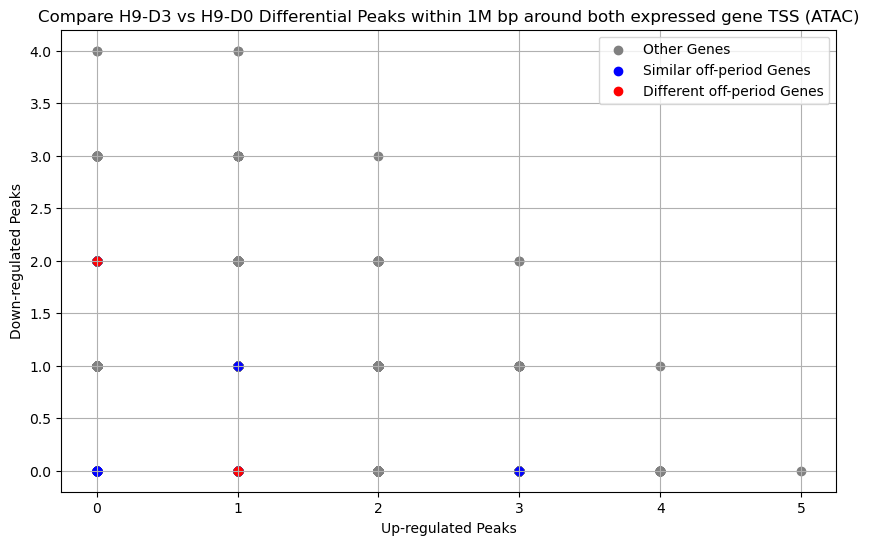

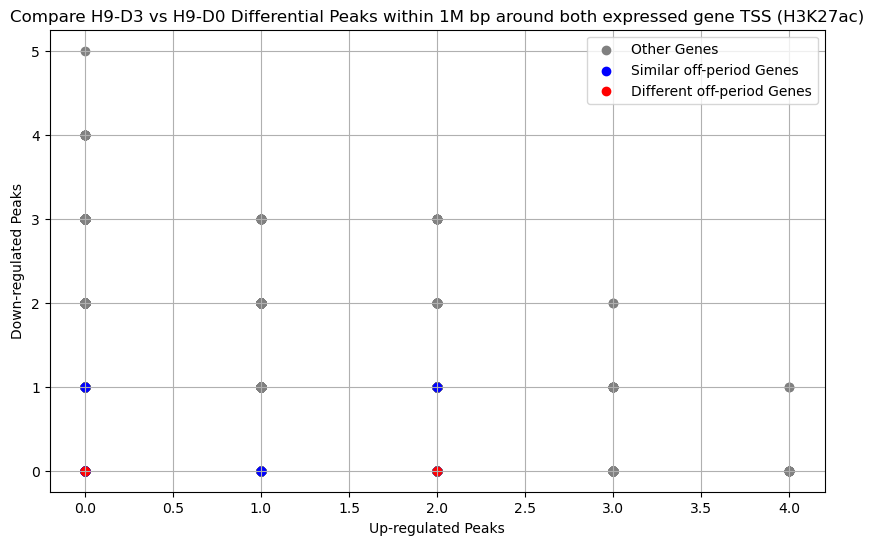

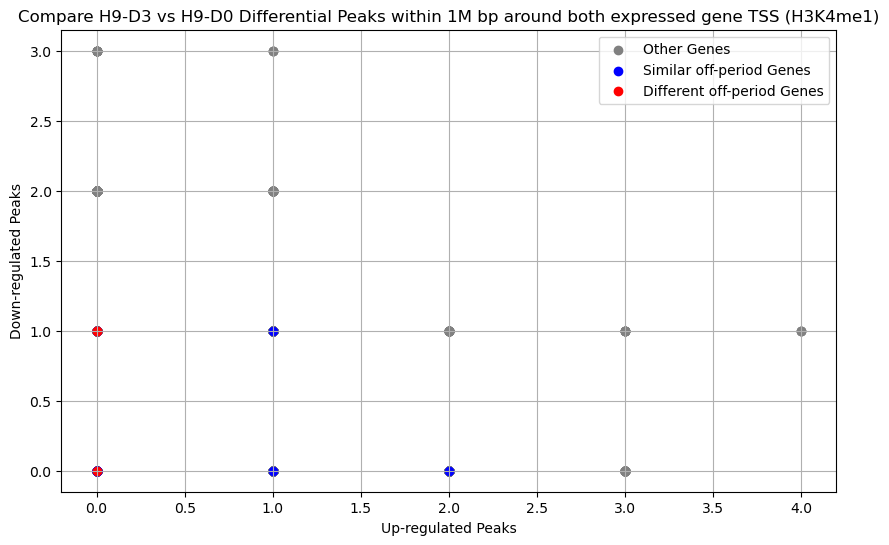

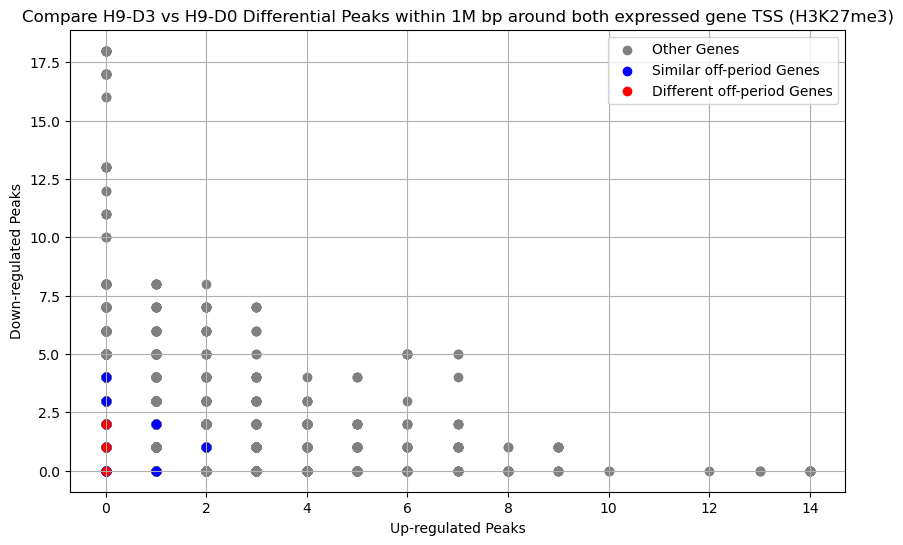

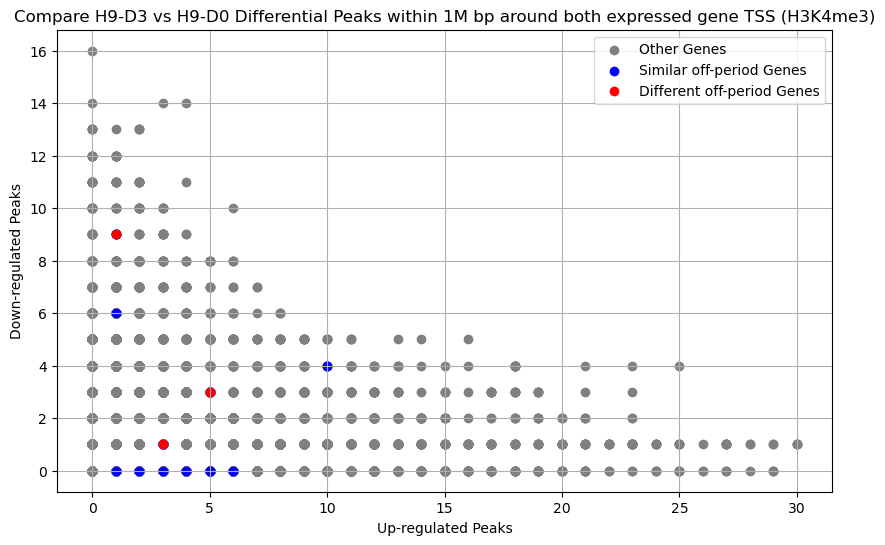

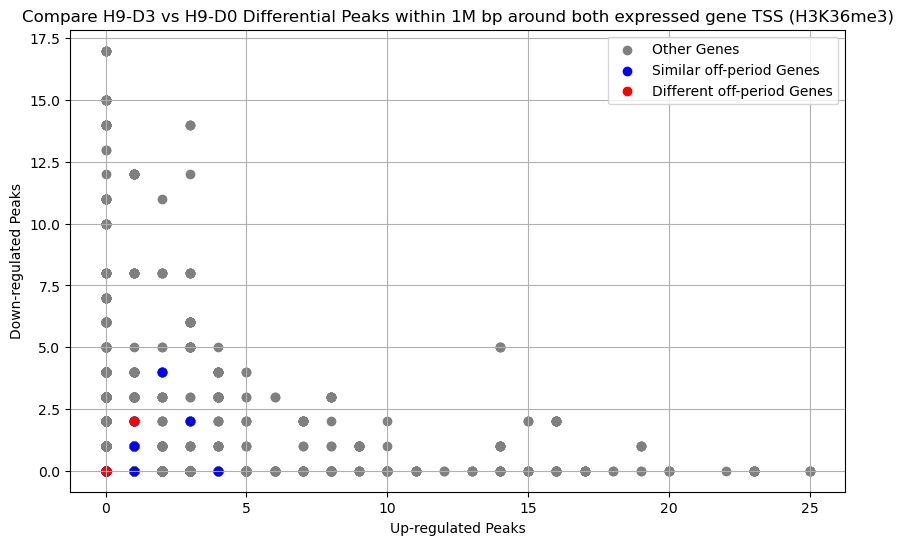

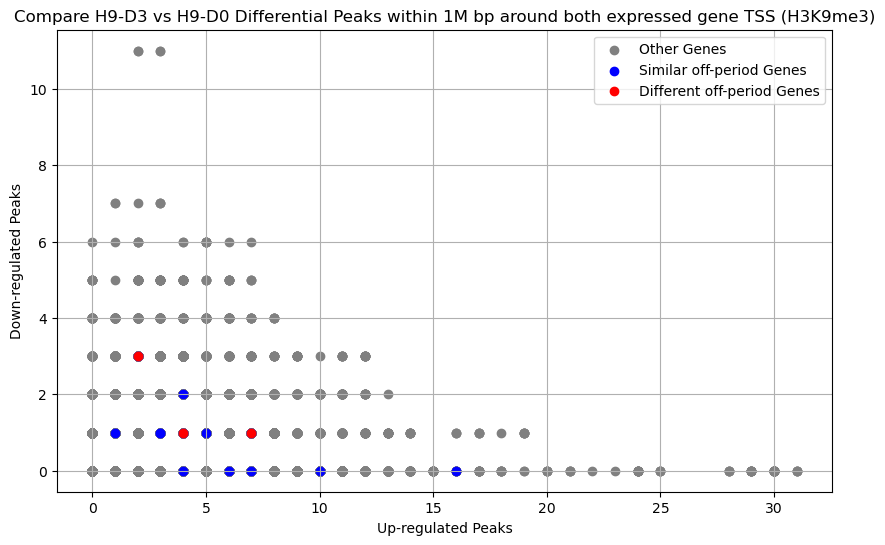

In [45]:

for histone in ["ATAC", "H3K27ac", "H3K4me1", "H3K27me3", "H3K4me3", "H3K36me3", "H3K9me3"]:

    df = res_df[res_df["Histone Mark"] == histone]

    # 创建散点图
    plt.figure(figsize=(10, 6))

    # 绘制其他基因
    other_genes = df[~df["Gene"].isin(diff_genes) & ~df["Gene"].isin(overlap_genes)]
    plt.scatter(other_genes["Up-regulated Peaks"], other_genes["Down-regulated Peaks"], color='grey', label='Other Genes')


    # 绘制重叠基因
    overlap_gene_rows = df[df["Gene"].isin(overlap_genes)]
    plt.scatter(overlap_gene_rows["Up-regulated Peaks"], overlap_gene_rows["Down-regulated Peaks"], color='blue', label='Similar off-period Genes')

    # 绘制差异基因
    diff_gene_rows = df[df["Gene"].isin(diff_genes)]
    plt.scatter(diff_gene_rows["Up-regulated Peaks"], diff_gene_rows["Down-regulated Peaks"], color='red', label='Different off-period Genes')


    # 设置图表标题和标签
    plt.title(f"Compare H9-D3 vs H9-D0 Differential Peaks within 1M bp around both expressed gene TSS ({histone})")
    plt.xlabel("Up-regulated Peaks")
    plt.ylabel("Down-regulated Peaks")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # # 保存图表
    # plt.savefig(f"figs/{histone}_differential_peaks.png")
    # plt.close()